## **Introduction**

In this lab, we learned about the logistic regression model, a popular and effective classification model. Understanding logistic regression and being able to apply it to classification tasks is essential because logistic regression models form the fundamentals of neural networks.


## **Objective**

We used a real-world dataset that contains detailed financial information about customers loan records. The objective is to classify whether a customer would be a Loan Defaulter or not. Based on the financial information in the dataset.

## **Setup**

For this lab, we will be using the following libraries:

 Pandas for managing the data.

 Numpy for mathematical operations.

 Seaborn for visualizing the data.

 Matplotlib for visualizing the data.

 Plotly.express for visualizing the data.

 Sklearn for machine learning and machine-learning-pipeline related functions.

In [260]:
# Surpress warnings from using older version of sklearn:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## **Installing Required Libraries**

In [261]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score


In [262]:
# also set a random state
rs = 123

## **Reading and understanding our data**

In [263]:
data = pd.read_csv('C:/Users/CCL/Downloads/Financial data - Sheet1.csv')
data.head()

,Customer ID,Annual income,Credit score,Employment length,Debt-to-income ratio,Loan default
0,1,"$65,000",680,2 years,0.24,0.0
1,2,"$40,000",590,1 year,0.37,1.0
2,3,"$95,000",720,5 years,0.16,0.0
3,4,"$35,000",530,6 months,0.50,1.0
4,5,"$80,000",710,4 years,0.27,0.0


 using `info` function, we will take a look at our types of data.

In [264]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer ID           58 non-null     int64  
 1   Annual income         57 non-null     object 
 2   Credit score          58 non-null     int64  
 3   Employment length     57 non-null     object 
 4   Debt-to-income ratio  57 non-null     float64
 5   Loan default          57 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 2.8+ KB


Next, we will check for any null values.

In [265]:
data.isnull().sum()

Customer ID             0
Annual income           1
Credit score            0
Employment length       1
Debt-to-income ratio    1
Loan default            1
dtype: int64

Now that we have found some null points, we need to either remove them from our dataset or fill them with something else. In this case, we will use `fillna()` and `method='ffill'`, which fills the last observed non-null value forward until another non-null value is encountered.

In [266]:
data = data.fillna(method='ffill')

#### **Transforming the 'Employment length' column**

Here, we will take a closer look at the 'Employment length' variable. Employment length is the duration a customer used in a particular place of work. In our dataset, the 'Employment length' is expressed as a string, in year(s) and months. To be recognized by machine learning algorithms, we need to transform it into numerical type.

The code below will iterate through each record in 'Employment length' column and convert it into months, as an additional separate column. The total employment length in months column will be useful feature for any regression type of analysis. In this case, logistic regression.


In [267]:

employment_length_in_months = []

employment_length = list(data['Employment length'])
for i in range(len(employment_length)):
    if employment_length[i].split()[1] == 'years' or employment_length[i].split()[1] == 'year' :
         employment_length_in_months.append(int(employment_length[i].split()[0]) * 12)
    elif employment_length[i].split()[1] == 'months':
        employment_length_in_months.append(int(employment_length[i].split()[0]))
      
data['Employment_length_in_months'] = employment_length_in_months    


In [268]:
# A similar approach is applied to the annual income column
annual_income_in_dollars = []

annual_income = list(data['Annual income'])
for i in range(len(annual_income)):
    if annual_income[i].split('$')[0] == '':
        annual_income_in_dollars.append(int(annual_income[i].split('$')[1].split(',')[0]) * 1000)
        
data['Annual_income_in_dollars'] = annual_income_in_dollars
        

Print 'data' data frame to see the newly created columns.

In [269]:
data.head()

,Customer ID,Annual income,Credit score,Employment length,Debt-to-income ratio,Loan default,Employment_length_in_months,Annual_income_in_dollars
0,1,"$65,000",680,2 years,0.24,0.0,24,65000
1,2,"$40,000",590,1 year,0.37,1.0,12,40000
2,3,"$95,000",720,5 years,0.16,0.0,60,95000
3,4,"$35,000",530,6 months,0.50,1.0,6,35000
4,5,"$80,000",710,4 years,0.27,0.0,48,80000


## **Feature Selection**

Here, we will select only those attributes which best explain the relationship of the independent variables with respect to the target variable, 'Loan default'. 

First, we will select only the relevant and newly transformed variables (and exclude variables such as 'customer ID'and 'Employment length), and place them into a 'new_data' data frame.

In [270]:
list(data.columns)

['Customer ID',
 'Annual income',
 'Credit score',
 'Employment length',
 'Debt-to-income ratio',
 'Loan default',
 'Employment_length_in_months',
 'Annual_income_in_dollars']

In [271]:
new_data = data.loc[:,['Annual_income_in_dollars',
 'Credit score', 'Debt-to-income ratio','Employment_length_in_months','Loan default']]

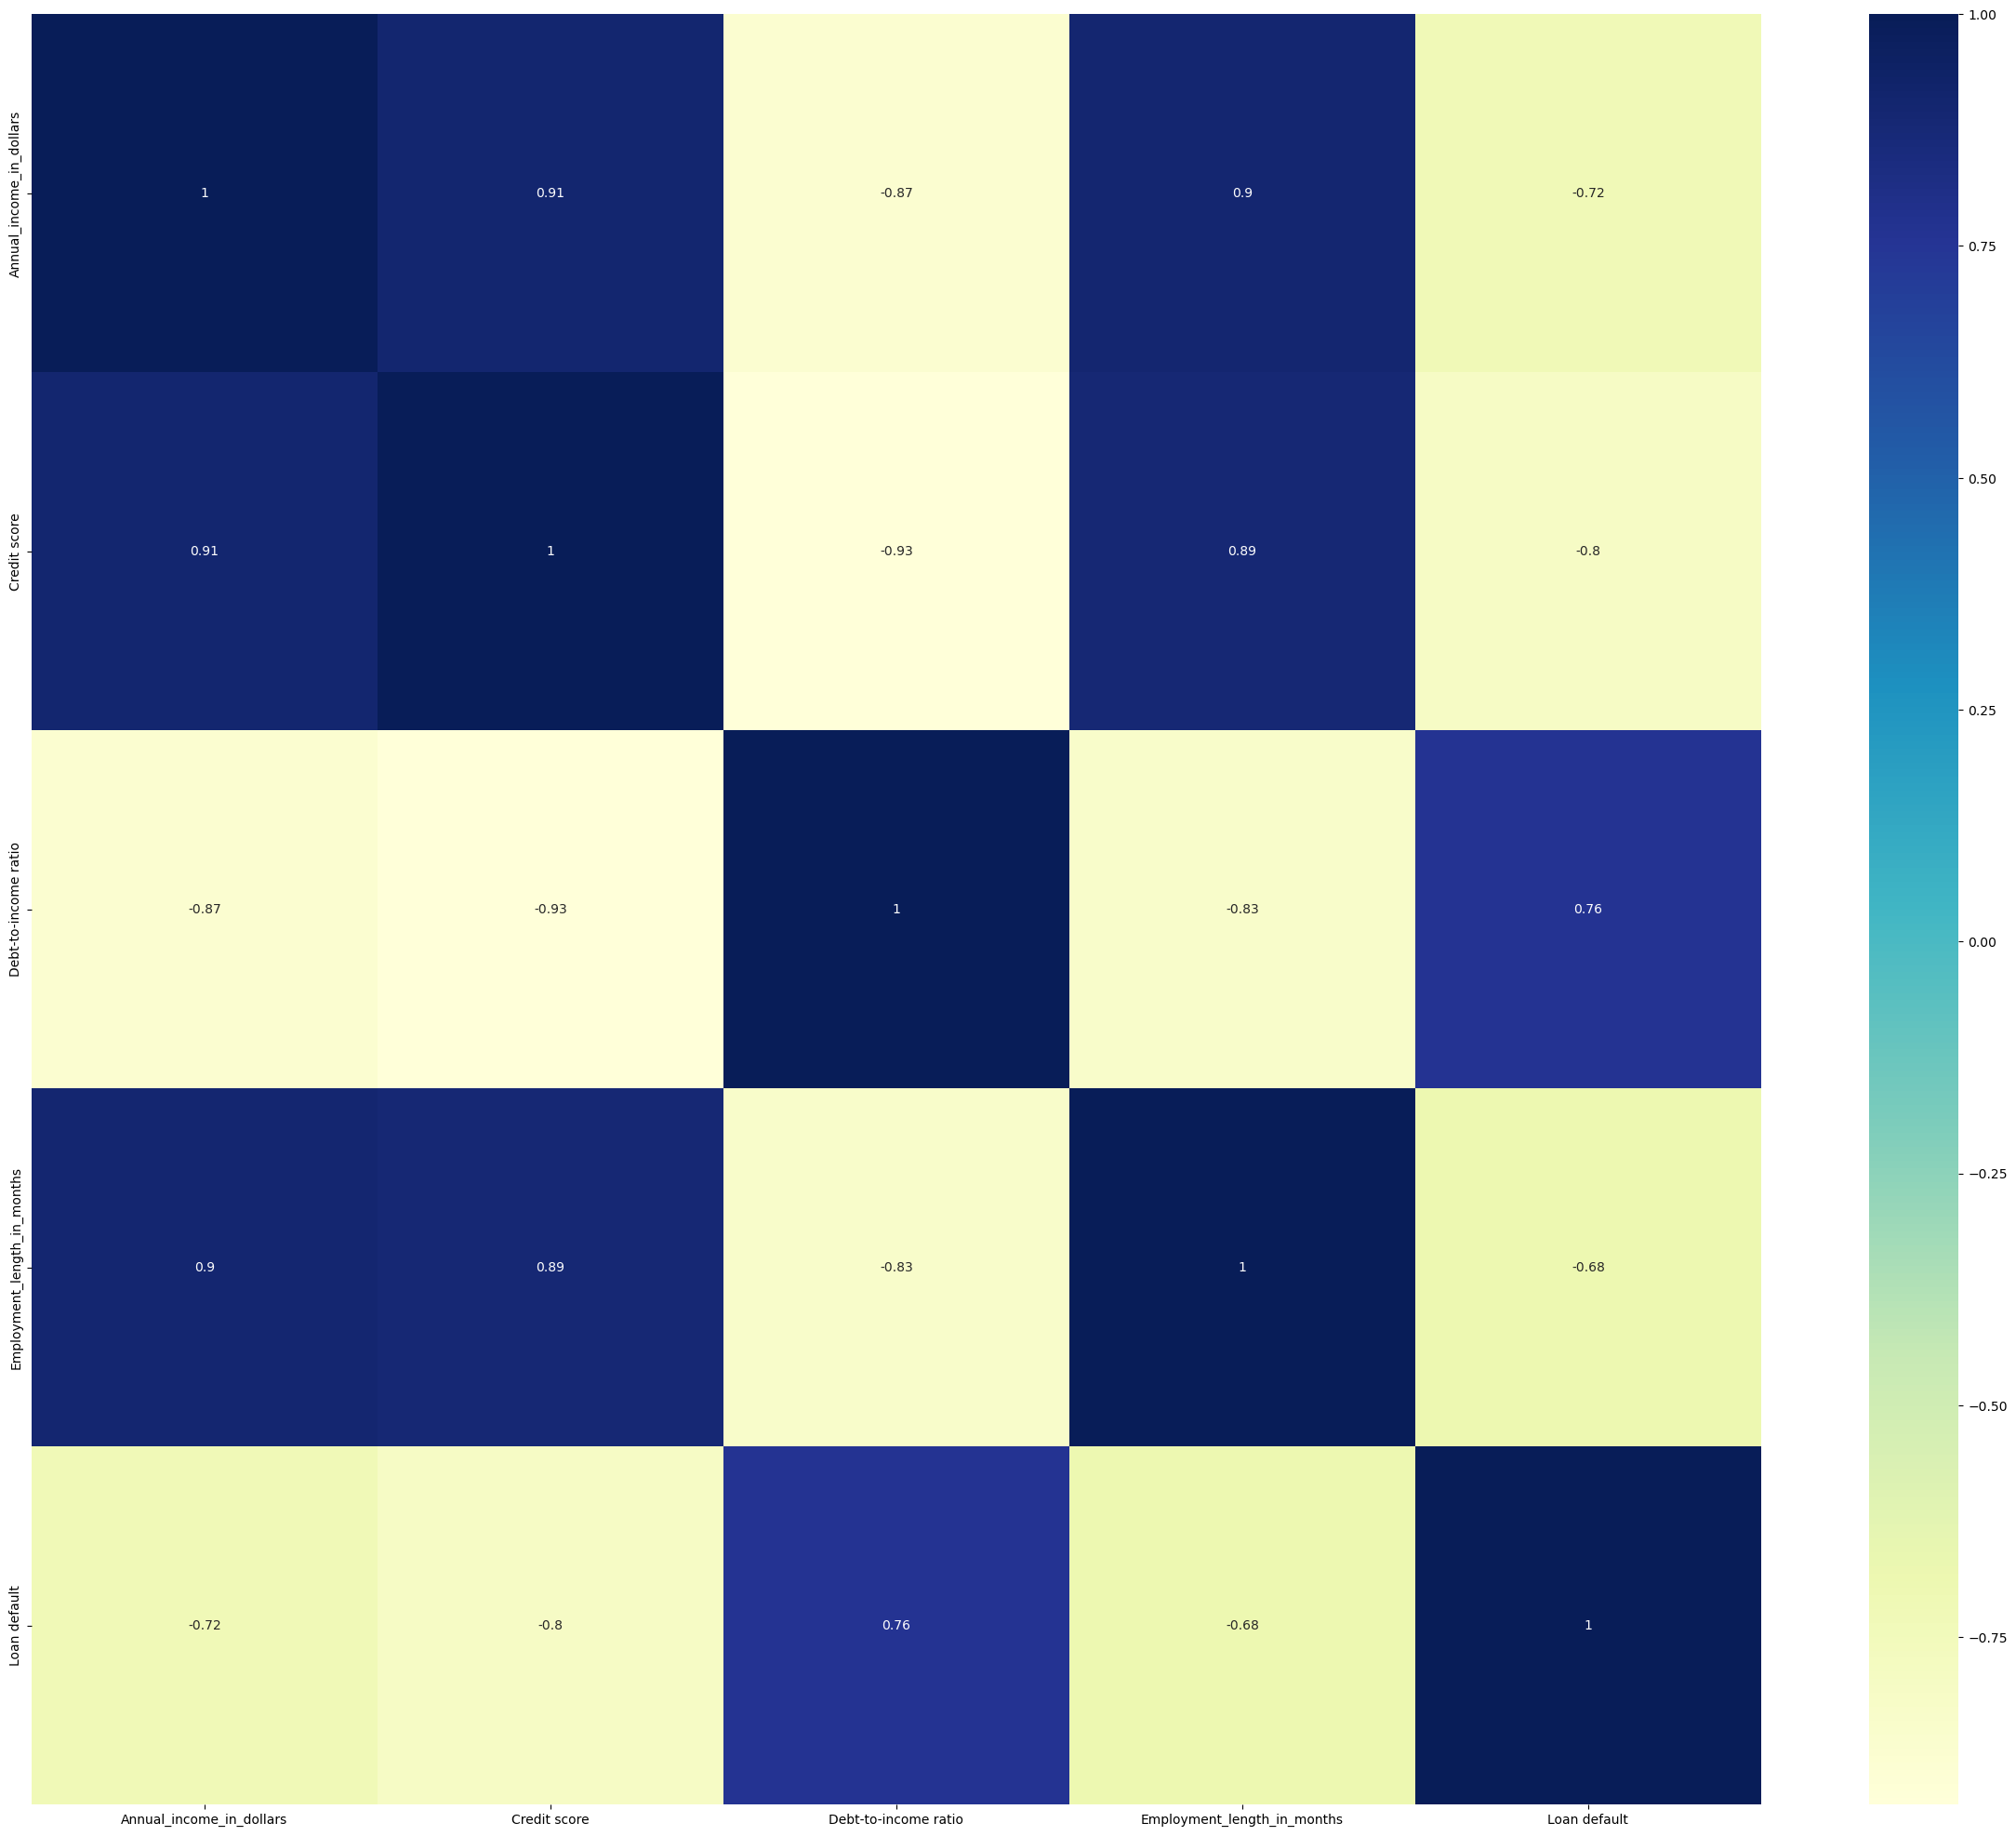

In [272]:
#Multicollinearity
num = new_data.select_dtypes(include = ['int64', 'float64']) 
plt.figure(figsize = (30, 25)) 
sns.heatmap(num.corr(), annot = True, cmap="YlGnBu")
plt.show()

Observation. As we can see, the multicollinearity still exists in various features.

In [273]:
feature_cols = list(new_data.iloc[:, :-1].columns)
feature_cols

['Annual_income_in_dollars',
 'Credit score',
 'Debt-to-income ratio',
 'Employment_length_in_months']

Obtain descriptive statistics:

In [274]:
new_data.iloc[:, :-1].describe()

,Annual_income_in_dollars,Credit score,Debt-to-income ratio,Employment_length_in_months
count,58.000000,58.000000,58.000000,58.000000
mean,68948.275862,674.310345,0.299310,38.482759
std,23568.803655,80.461652,0.117501,24.210511
min,35000.000000,520.000000,0.110000,6.000000
25%,45750.000000,610.000000,0.205000,12.000000
50%,70000.000000,695.000000,0.280000,36.000000
75%,88750.000000,730.000000,0.395000,60.000000
max,115000.000000,800.000000,0.520000,84.000000


As we can see from the above output, this dataset contains 4  categories about each customer. These categories include Annual income in dollars, Credit score, Debt-to-income ratio and Employment length in months etc., and are listed as numeric variables. As such, we only need to scale them for training our logistic regression model so that we can compare our feature coefficients directly.

Next, let's check the target variable in the `Loan default` column to see the label values and their distribution.

In [275]:
# # Get the row entries with the last col 'Loan default'
new_data.iloc[:, -1:].value_counts(normalize=True)

Loan default
0.0             0.689655
1.0             0.310345
dtype: float64

The customer defaulted on loan (1) or the customer didn't default on loan (0)

<AxesSubplot:xlabel='Loan default'>

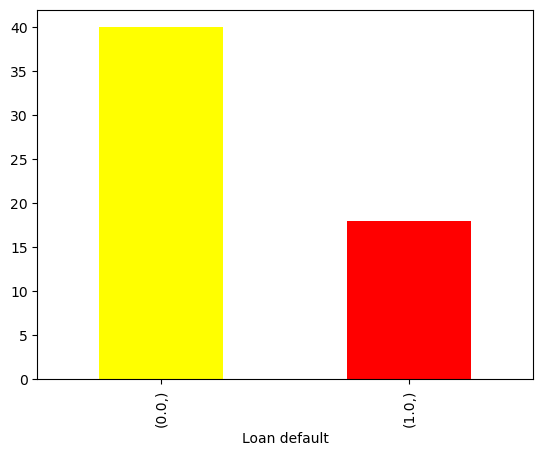

In [276]:
new_data.iloc[:, -1:].value_counts().plot.bar(color=['yellow', 'red'])

As we can see from the bar chart above, this dataset has two classes: `Loan Defaulter` (1) and `Non Loan Defaulter` (0). The two labels are imbalanced. We could build a machine learning model to help in weeding out the bad eggs (defaulters).

A binary logistic regression is a generalized logistic regression model which generates a probability distribution over all classes, based on the logits or exponentiated log-odds calculated for each class (usually two).

### **Feature Engineering**

Next, let's process the raw dataset and construct input data `X` and label/output `y` for logistic regression model training.


In [277]:
X_raw = new_data.iloc[:, :-1]
y_raw = new_data.iloc[:, -1:]

Fortunately, all feature columns are numeric so we just need to scale them. Here we use the `MinMaxScaler` provided by `sklearn` for scaling.

In [278]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

In [279]:
# Scaling the raw input features
X = scaler.fit_transform(X_raw)

Let's check the scaled feature value range:

In [280]:
print(f"The range of feature inputs are within {X.min()} to {X.max()}")

The range of feature inputs are within 0.0 to 1.0000000000000002


For the target variable `y`, let's use the `LabelEncoder` provided by `sklearn` to encode its three class values.

In [281]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

In [282]:
# Encode the target variable
y = label_encoder.fit_transform(y_raw.values.ravel())


The encoded target variable will only contain values `0= Non Loan Defaulter`, `1=Loan Defaulter`

In [283]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([40, 18], dtype=int64))

# Train logistic regression models

First, let's split the training and testing dataset. Training dataset will be used to train and tune models, and testing dataset will be used to evaluate the models. Note that you may also split a validation dataset from the training dataset for model tuning only.

In [284]:
# First, let's split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

Let's look at the shapes of the split datasets:


In [285]:
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")

Training dataset shape, X_train: (46, 4), y_train: (46,)


In [286]:
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Testing dataset shape, X_test: (12, 4), y_test: (12,)


OK, now we have the training and testing datasets ready, let's start the model training task.

We first define a `sklearn.linear_model.LogisticRegression` model with the following arguments, you can check the comment for each argument for what it means.

In [287]:
# elasticnet penalty to shrink coefficients without removing any features from the model
penalty= 'elasticnet'
# Our classification problem is binary
multi_class = 'auto'
# Use saga for elasticnet penalty and multinomial classes
solver = 'saga'
# Max iteration = 1000
max_iter = 1000
#The penalty is  L1. 
l1_ratio = 1

In [288]:
# Define a logistic regression model with above arguments
l2_model = LogisticRegression(random_state=rs, penalty=penalty, multi_class=multi_class, solver=solver, max_iter=max_iter, l1_ratio=l1_ratio)

Let's train the model with training input data X_train and labels y_train:

In [290]:
l2_model.fit(X_train, y_train)

LogisticRegression(l1_ratio=1, max_iter=1000, penalty='elasticnet',
                   random_state=123, solver='saga')

In [291]:
l2_preds = l2_model.predict(X_test)

Because we may need to evaluate the model multiple times with different model hyper parameters, here we define an utility method to take the ground truths y_test and the predictions preds, and return a Python dict with accuracy, recall, precision, and f1score.

In [292]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [293]:
evaluate_metrics(y_test, l2_preds)

{'accuracy': 1.0,
 'recall': array([1., 1.]),
 'precision': array([1., 1.]),
 'f1score': array([1., 1.])}

As we can see from the above evaluation results, the logistic regression model has relatively good performance on this binary classification task. The overall accuracy is around 1.0 and the f1score is around 1.0.

We can also plot the confusion matrix based on the true labels and predictions using the `confusion_matrix` method provided by `sklearn`,


In [294]:
cf = confusion_matrix(y_test, l2_preds)

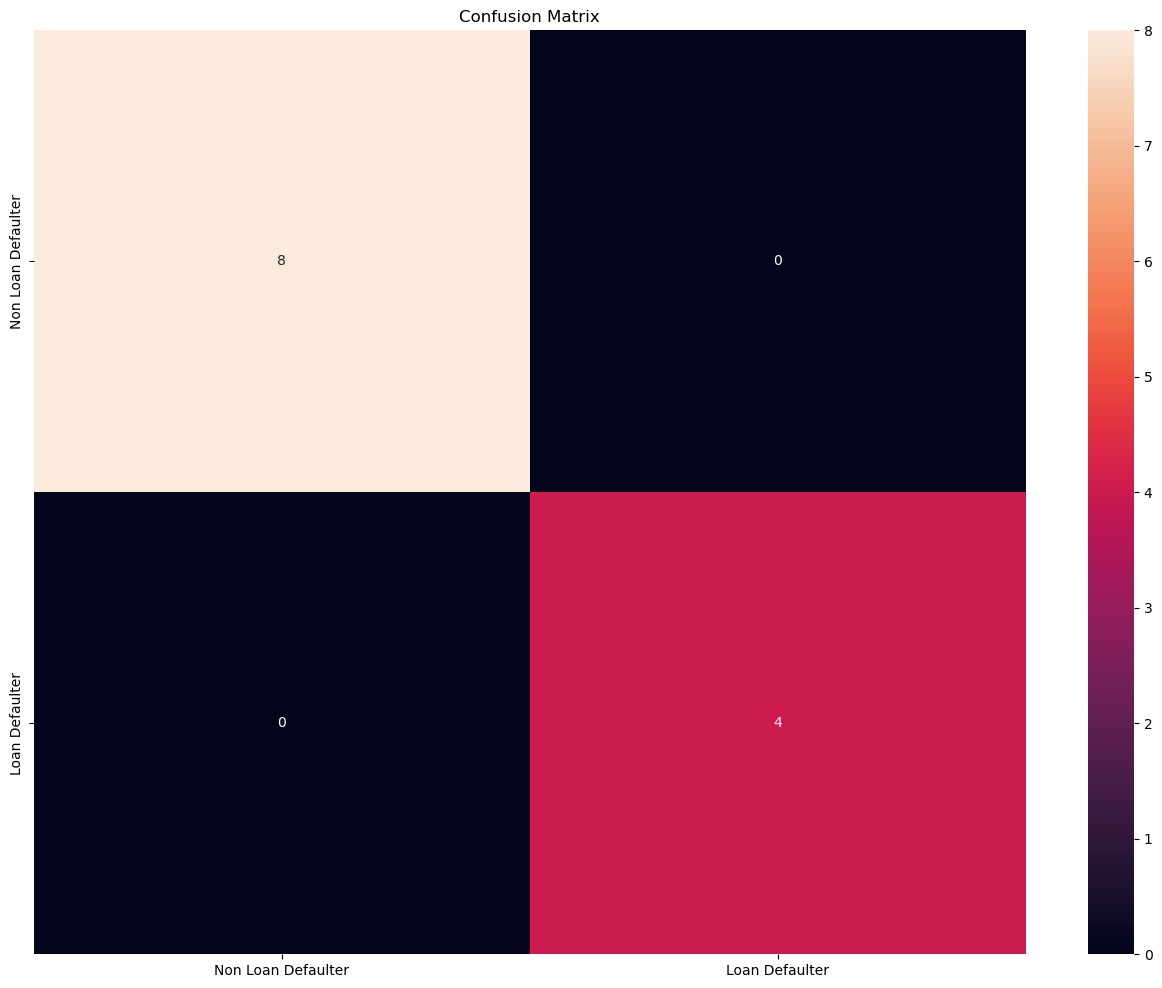

In [295]:
plt.figure(figsize=(16, 12))
ax = sns.heatmap(cf, annot=True, fmt="d", xticklabels=["Non Loan Defaulter", "Loan Defaulter"], 
                 yticklabels=["Non Loan Defaulter", "Loan Defaulter"])
ax.set(title="Confusion Matrix");

### Interpret logistic regression models

One way to interpret logistic regression models is by analyzing feature coefficients. Although it may not be as effective as the regular linear regression models because the logistic regression model has a sigmoid function, we can still get a sense for the importance or impact of each feature.


We can check the coefficients for logistic regression model using its `coef_` attribute:

In [296]:
l2_model.coef_

array([[-1.31902654, -4.78885347,  0.10895115,  0.        ]])

The `coef_` is a coefficients list with three elements, one element is the actual coefficent for class 0, 1. To better analyze the coefficients, let's use three utility methods to sort and visualize them.


In [297]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()

Then, let's visualize the sorted coefficient for class 0, the Non Loan default class:

In [298]:
# Get the coefficents for Class 1, Less Often
coef_dict = get_feature_coefs(l2_model, 0, feature_cols)

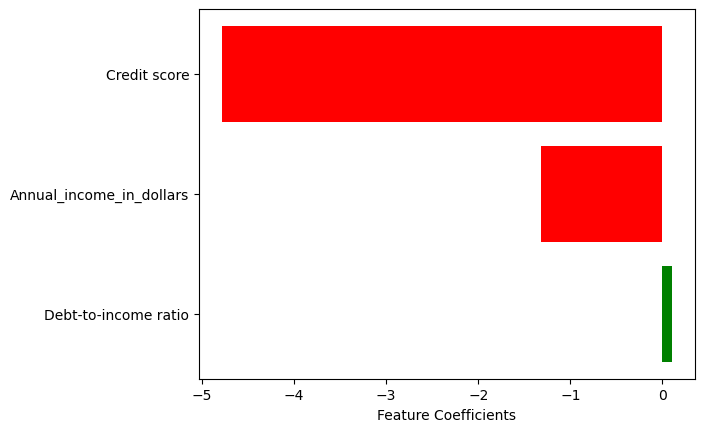

In [299]:
visualize_coefs(coef_dict)

As we can see, debt-to-income ratio have low positive coefficients.  If a customer has a high credit score and an annual income, then it is unlikely to be categorized in the 'Loan Defaulter' class.

## **References**

IBM Skills Network https://skills.network/


## **Thank you**

***

## **Author**

Adedoyinsola Ogungbesan